# ARIMA Tutorial

In this example, we'll apply models from the ARIMA family to a simple regressive model.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10
matplotlib.rcParams['figure.figsize'] = (15, 6)

We'll use the well-known air passengers time series for this example. 

First, let's download sample dataset directly from the mlcollege github account.

Notice the date parsing function that allows us to build an index on this time series.

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/mlcollege/time-series-analysis-v2/master/data/AirPassengers.csv', 
                   parse_dates=True, index_col='Month', date_parser=lambda x: datetime.strptime(x, '%Y-%m'))
ts = data['#Passengers']
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Now let's see how the time series looks like. 


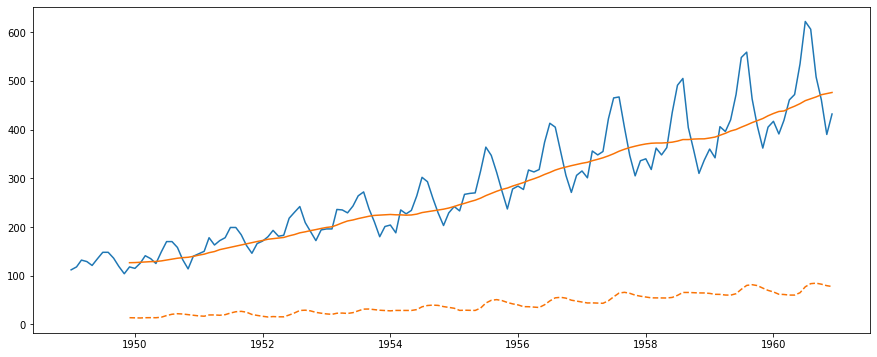

In [3]:
rolling = ts.rolling(center=False, window=12)        
plt.plot(ts)
plt.plot(rolling.mean(), color="xkcd:orange")
plt.plot(rolling.std(),  color="xkcd:orange", linestyle="--")
plt.show()

### let's take 2 years of data as a validation set

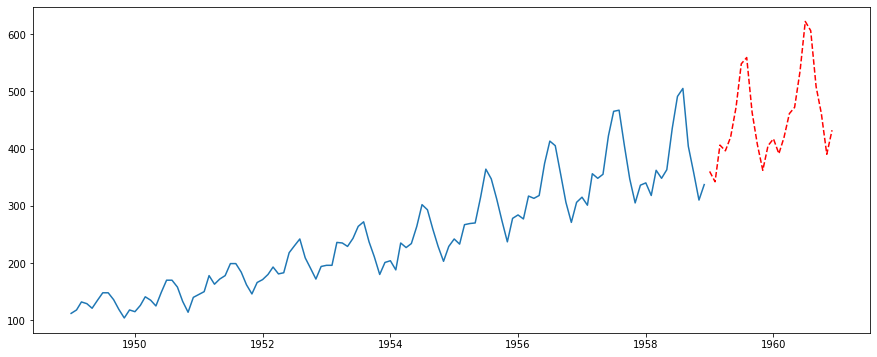

In [4]:
VALIDATION_MARK = 24

training_ts = ts[:-VALIDATION_MARK]
validation_ts = ts[-VALIDATION_MARK:]

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.show()

## ARIMA Models

Let's try to fit an ARIMA model onto our data now. We need to make the time series *stationary* before.

### Stationarity 

Stationarity is a useful concept for time series analysis as it tell's us something about stability of the time series over time. 

Time series is stationary if the following conditions are fulfilled:

1. The mean of the series should not be a function of time
2. The variance of the series should not a be a function of time
3. The covariance of the i-th term and the (i + k)-th term should not be a function of time

*Note: One should always consider a scale from which the data is viewed. 
For example, a quarter year of temperature data from Europe will not look stationary but if viewed on a daily basis, it can indeed seems like a stationary time series.*

###Dickey–Fuller test (ADF)

Stationary time series are easier to predict. We can just assume that if all the statistics are constant in time then they will remain constant in future as well. 

There's a statistical test for testing stationarity of the time series. It's called augmented Dickey–Fuller test (ADF) tests the null hypothesis that the time series is not stationary.


In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):        
    rolling = ts.rolling(center=False, window=12)            
    plt.plot(ts, label='Original')
    plt.plot(rolling.mean(), color="xkcd:orange")
    plt.plot(rolling.std(),  color="xkcd:orange", linestyle="--")
    plt.legend(loc='upper left')    
    plt.show()        
    
    df_test = adfuller(ts)
    output = list(zip(['Test Statistic','p-value','#Lags Used','#Observations Used'], df_test[0:4]))        
    output.extend([('Critical Value (%s)' % key, value) for key, value in sorted(df_test[4].items(), key=lambda x: x[1], reverse=True)])
                
    print('Dickey-Fuller test:')  
    for key, value in output:  
        print(key.ljust(25), value)

When ADF is applied to the original time series, the p-value clearly suggests that null hypothesis cannot be rejected i.e. the time series is not stationary.

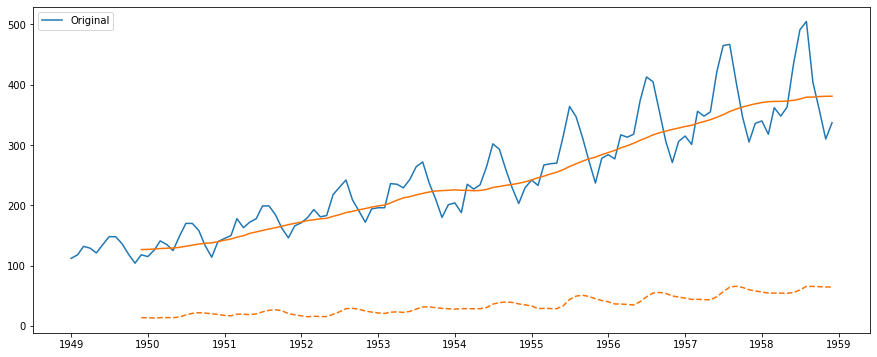

Dickey-Fuller test:
Test Statistic            -0.773460770896928
p-value                   0.8267937485032476
#Lags Used                13
#Observations Used        106
Critical Value (10%)      -2.58153320754717
Critical Value (5%)       -2.8892174239808703
Critical Value (1%)       -3.4936021509366793


In [6]:
test_stationarity(training_ts)

## Let's remove trend, seasonality and inflation

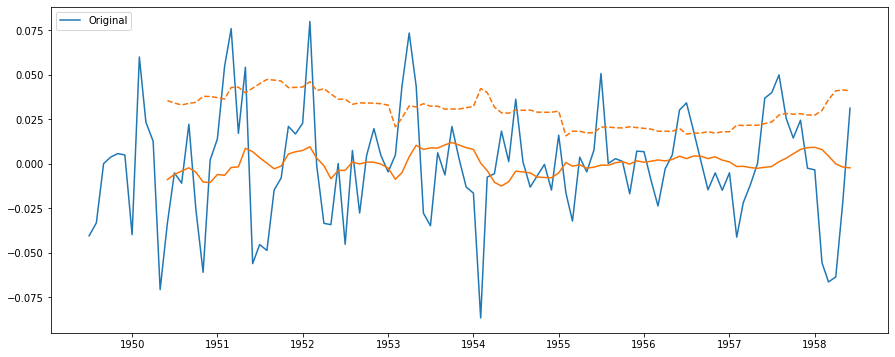

Dickey-Fuller test:
Test Statistic            -6.185134187963251
p-value                   6.316179735123273e-08
#Lags Used                7
#Observations Used        100
Critical Value (10%)      -2.5824349
Critical Value (5%)       -2.89090644
Critical Value (1%)       -3.497501033


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
log_ts = np.log(training_ts)
decomposition = seasonal_decompose(log_ts, model='aditive')
test_stationarity(decomposition.resid.dropna())

## ARIMA model

As ARIMA can work with trend, we will try to model residuals + trend

In [8]:
from statsmodels.tsa.arima.model import ARIMA
tr_arima = decomposition.resid + decomposition.trend

model = ARIMA(tr_arima, order=(2, 2, 2), freq="MS")  
results = model.fit()


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
from sklearn.metrics import r2_score, mean_squared_error

def get_metrics(*args):
    return (
        f'R^2: {r2_score(*args):.4f}, ' +        
        f'MSE: {mean_squared_error(*args):.4f}, '        
    )

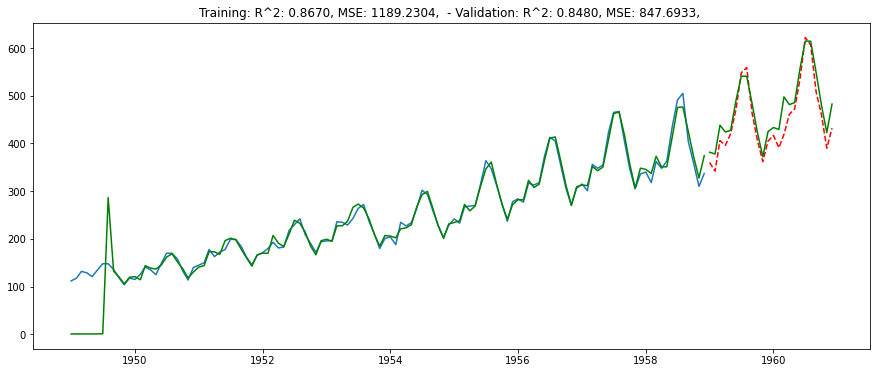

In [10]:
from datetime import timedelta

prediction = results.predict(start=training_ts.index[-1], end=training_ts.index[-1] + timedelta(days=365 * 2 + 1))
## lets add seasonality
season = decomposition.seasonal.values[-12:]
forecast_season = np.concatenate((season, season))

inflated = np.exp(results.fittedvalues + decomposition.seasonal)
inflated_prediction = np.exp(prediction[1:] + forecast_season)


plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.plot(inflated, c='g')
plt.plot(inflated_prediction, c='g')
plt.title(
     f'Training: {get_metrics(training_ts, inflated)} - Validation: {get_metrics(validation_ts, inflated_prediction)}'    
)
plt.show()

### SARIMAX Model

There are more advanced models like SARIMAX that can hande even seasonal data. The usage is very similar although there are two sets of hyper parameters. One for the global scale (same as in the ARIMA model) and the second for the local seasonal elements (acompanied with the season length)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


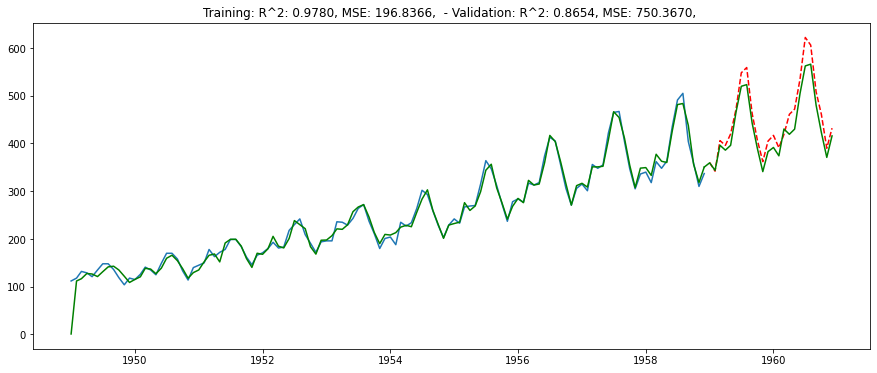

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

log_ts = np.log(training_ts)

model = SARIMAX(log_ts, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), freq="MS")
results = model.fit(maxiter=100)

prediction = results.get_prediction(start=training_ts.index[-1], end=training_ts.index[-1] + timedelta(days=365 * 2 + 1), dynamic=True)

prediction_mean = np.exp(prediction.predicted_mean)
fitted = np.exp(results.fittedvalues)

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.plot(fitted, c='g')
plt.plot(prediction_mean, c='g')
plt.title(
    f'Training: {get_metrics(training_ts, fitted)} - Validation: {get_metrics(validation_ts, prediction_mean[1:])}'    
)
plt.show()